In [70]:
from itertools import chain
import pandas as pd
import numpy as np
from re import T
from sklearn.metrics import mean_squared_error
from math import sqrt
import markovify
id=0

############ load and digitize the data
data=pd.read_csv('/home/ebotian/MCM/tennis2.csv')

############

############# pre-process the data
    # fill nan with 0, and replace AD with 50
def pre_process(data):
    data = pd.get_dummies(data, columns=['winner_shot_type','serve_width','serve_depth','return_depth'])
    data = data.fillna(0)
    data = data.replace('AD', 50.0)
    data['point_victor']=data["point_victor"].replace(2,0)
    #print(data.iloc[:,15])

    # split the data into different match
    grouped = dict(tuple(data.groupby(data['match_id'].ne(data['match_id'].shift()).cumsum())))

    # Rename the subdata
    subdata = {df['match_id'].iloc[0]: df for _, df in grouped.items()}

    # Create a new dataset from the first column, excluding duplicates
    match = pd.DataFrame(data.iloc[:, 0].drop_duplicates()).iloc[:,0].tolist()
    return subdata,match

subdata,match=pre_process(data)
#print(subdata[match[1]])
##############

def process_all_ids(subdata):
    for id in range(len(match)):
        index_array = subdata[match[id]][subdata[match[id]]['server'] == 2].index.values
        subdata[match[id]].loc[index_array, 'point_victor'] = 1 - subdata[match[id]].loc[index_array, 'point_victor']
        target=pd.DataFrame(subdata[match[id]]["point_victor"])
        # Add the "elapsed_time" column to the "target" DataFrame
        subdata[match[id]]['elapsed_time'] = pd.to_timedelta(subdata[match[id]]['elapsed_time'])
        target.insert(0, 'elapsed_time', subdata[match[id]]['elapsed_time'])
        target['elapsed_time'] = target['elapsed_time'].dt.total_seconds()
        #subdata[match[id]]=subdata[match[id]].drop(columns=["point_victor"])
        features=subdata[match[id]].drop(columns=["point_victor"]).iloc[:,4:]

    return target,features,subdata,index_array

# Replace with your actual match ids
target,features,subdata,index_array=process_all_ids(subdata)
#print(subdata[match[1]])
##############
##############
#invert the victor when the server is 2 to get server_victor
#and after the prediction, we invert the victor again
# Get the index array


# Invert the values in the "point_victor" column for the specified rows

#print(index_array)
##############
# Calculate the time difference between consecutive rows
def get_average_interval(id, subdata):

    # Calculate the time difference between consecutive rows
    subdata[match[id]]['time_diff'] = subdata[match[id]]['elapsed_time'].diff()

    # Calculate the 5th and 95th percentiles
    lower_threshold = subdata[match[id]]['time_diff'].quantile(0.05)
    upper_threshold = subdata[match[id]]['time_diff'].quantile(0.95)

    # Exclude the top 5% and bottom 5% of periods
    filtered_diff = subdata[match[id]]['time_diff'][(subdata[match[id]]['time_diff'] > lower_threshold) & (subdata[match[id]]['time_diff'] < upper_threshold)]

    # Calculate the average of the remaining intervals
    average_interval = filtered_diff.mean()

    return average_interval


In [71]:
import pandas as pd

def create_markov_chain(id, subdata):
  # Define extended states
  extended_states = [
    'P1_serve_win', 'P1_serve_lose',
    'P2_serve_win', 'P2_serve_lose'
  ]

  # Get the match data for the given id
  subdata[match[id]]["point_victor"]= subdata[match[id]]["point_victor"].replace(0,2)

  # Initialize transition count matrix
  transition_counts = pd.DataFrame(0, index=extended_states, columns=extended_states)
  match_data=subdata[match[id]]

  # Iterate over the match data
  for i in range(1, len(match_data)):
    prev_point = match_data.iloc[i-1]
    curr_point = match_data.iloc[i]

    # Determine the state of the previous and current point
    prev_state = 'P{}_serve_{}'.format(prev_point['server'], 'win' if prev_point['point_victor'] == prev_point['server'] else 'lose')
    curr_state = 'P{}_serve_{}'.format(curr_point['server'], 'win' if curr_point['point_victor'] == curr_point['server'] else 'lose')

    # Update transition counts
    transition_counts.loc[prev_state, curr_state] += 1

  # Calculate transition probabilities
  transition_probabilities = transition_counts.div(transition_counts.sum(axis=1), axis=0)

  return transition_probabilities

# Initialize list to store transition matrices
transition_matrices = []

# Iterate over the range of the number of matches
for id in range(len(match)):
    # Create transition matrix for current match
    transition_matrix = create_markov_chain(id, subdata)

    # Add transition matrix to list
    transition_matrices.append(transition_matrix)

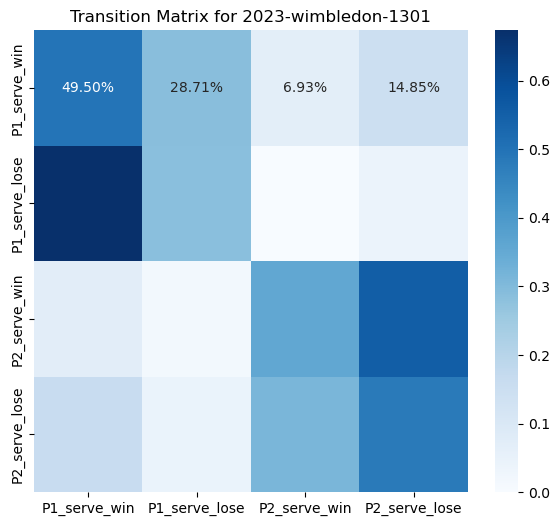

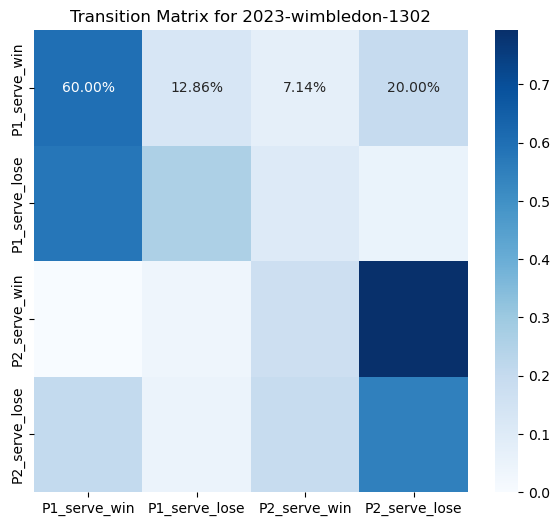

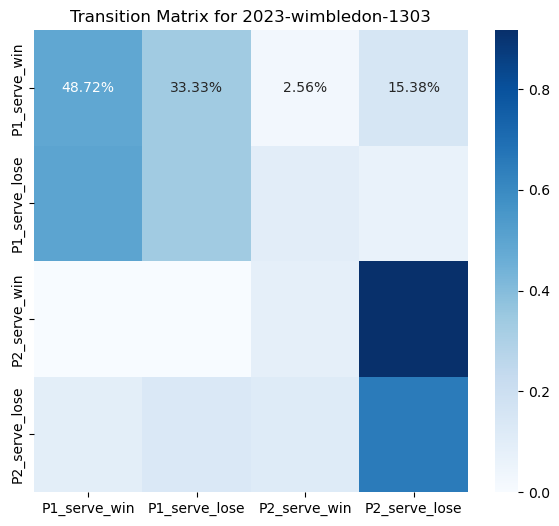

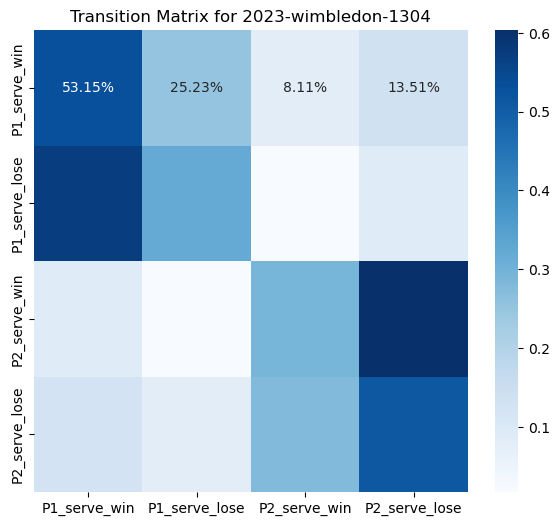

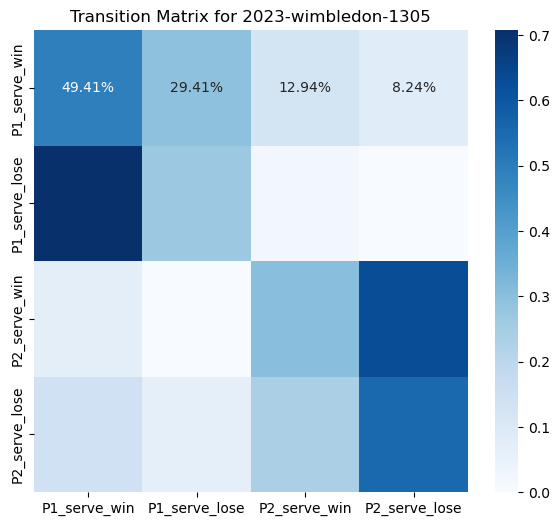

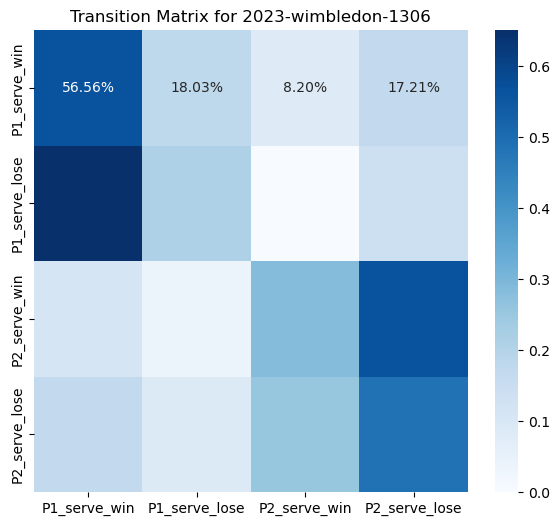

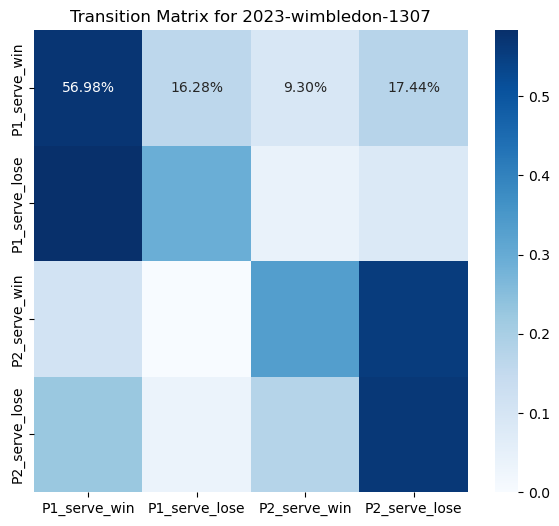

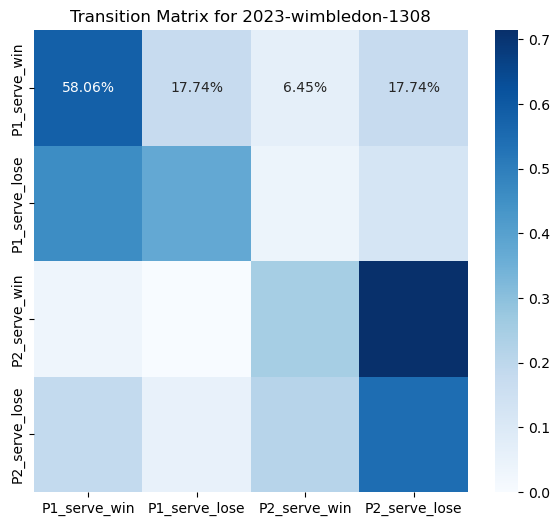

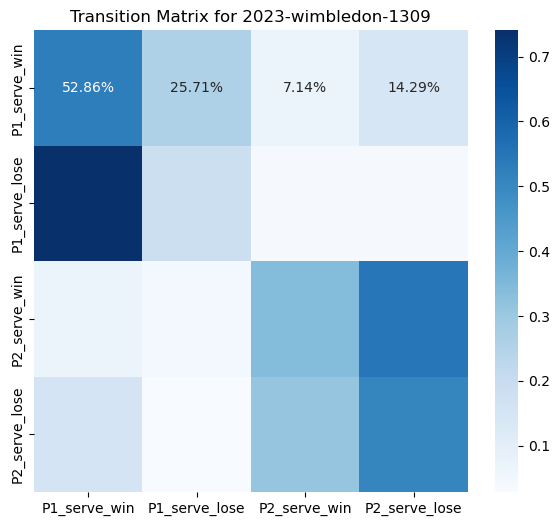

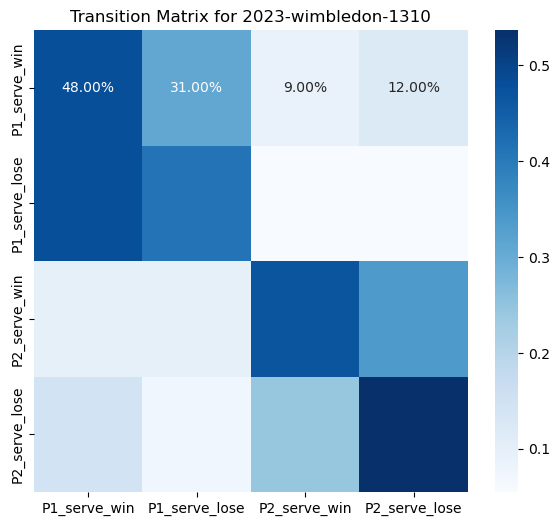

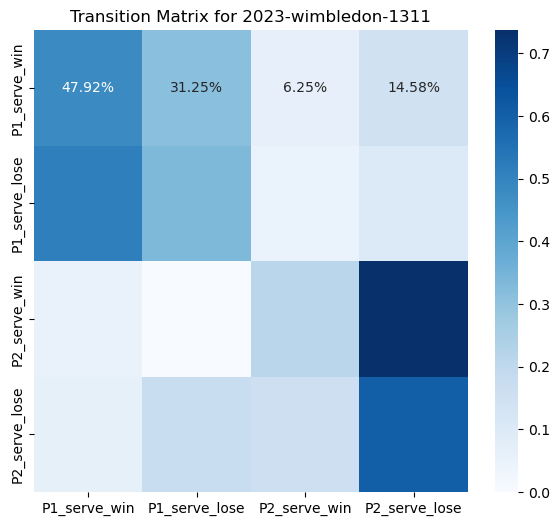

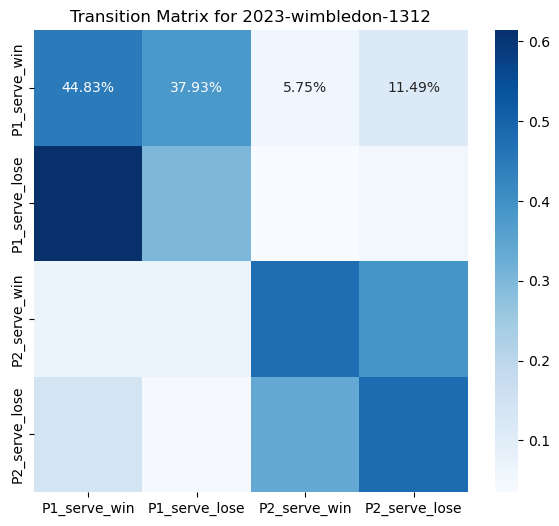

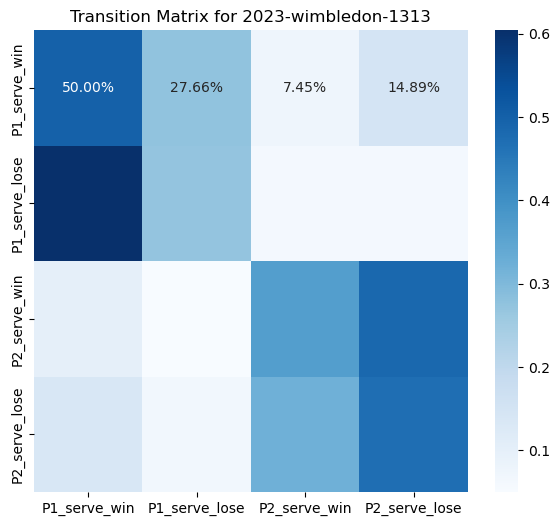

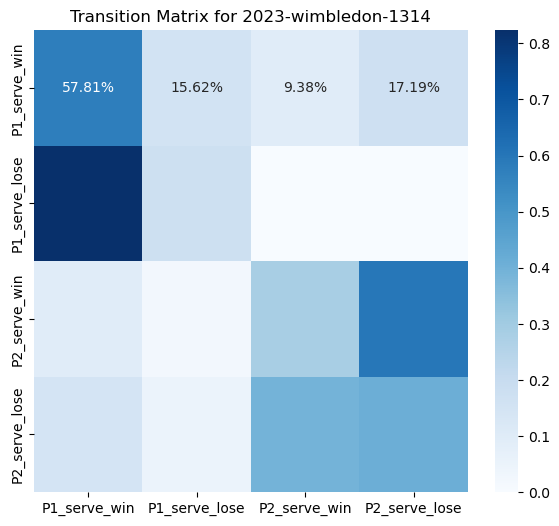

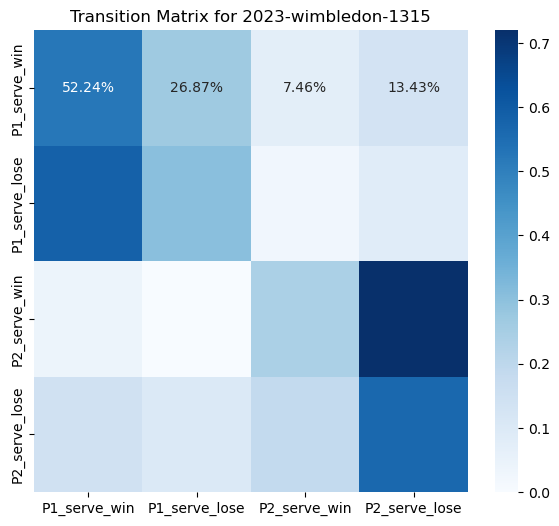

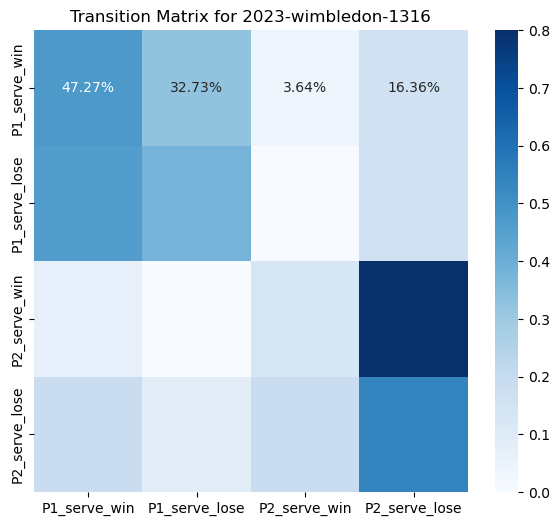

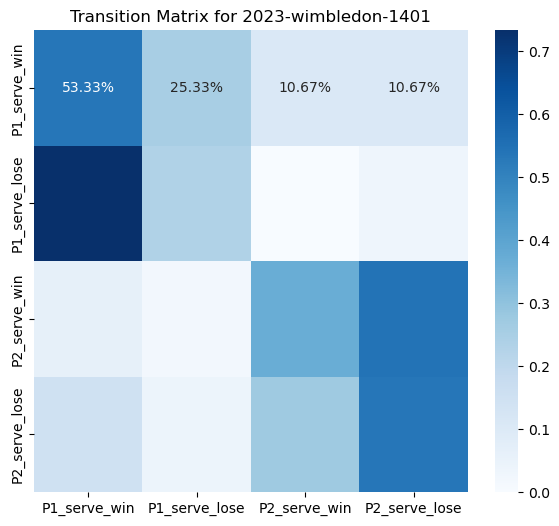

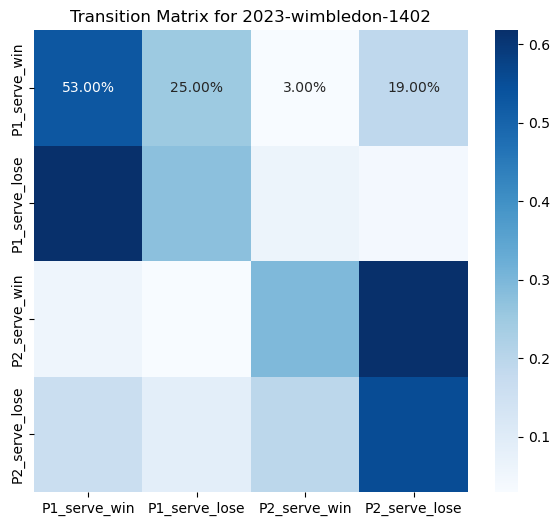

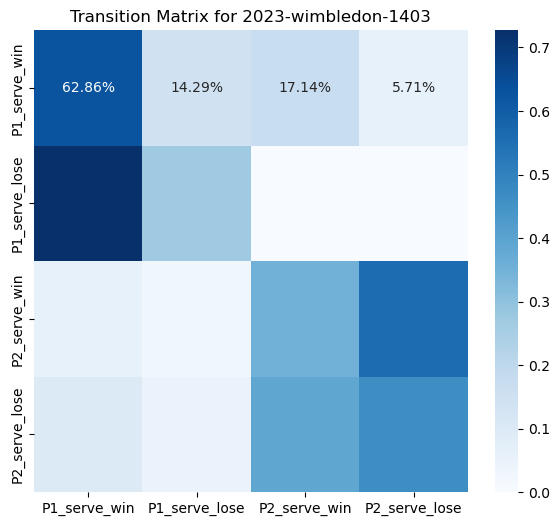

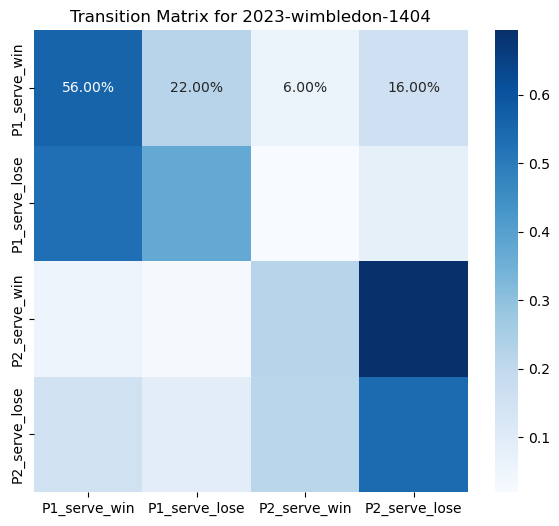

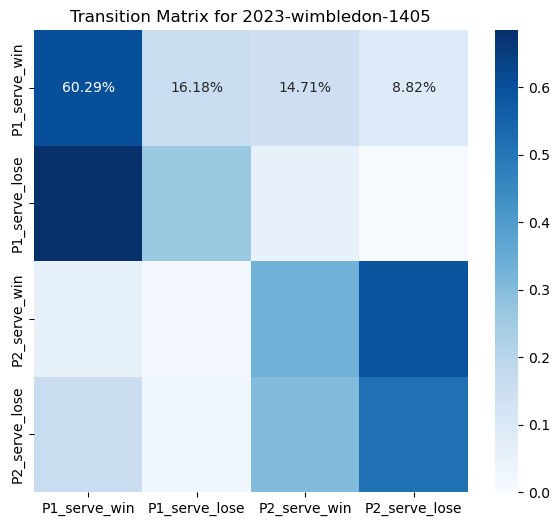

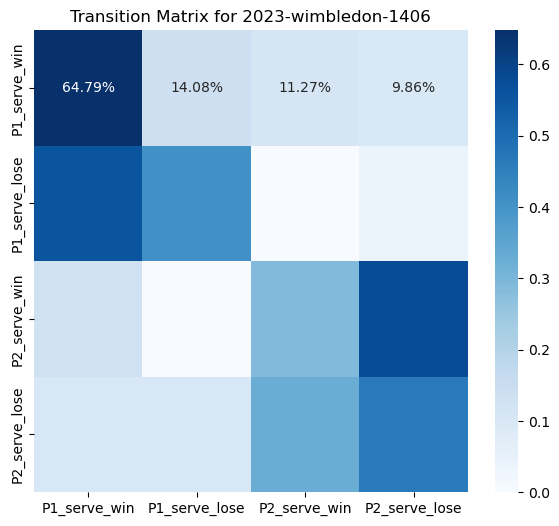

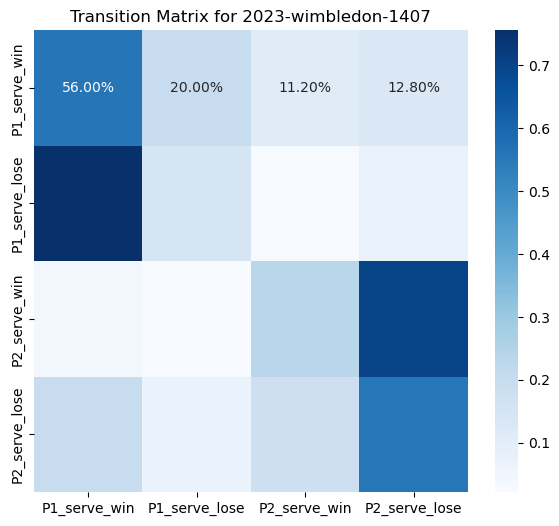

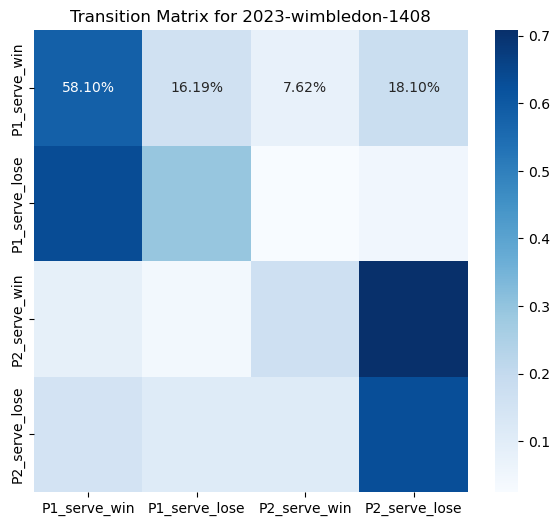

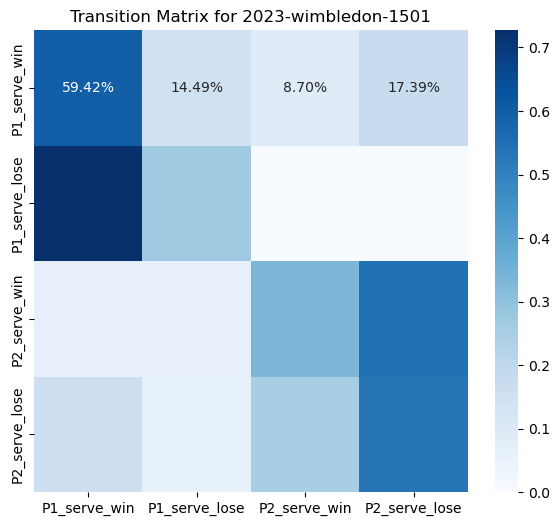

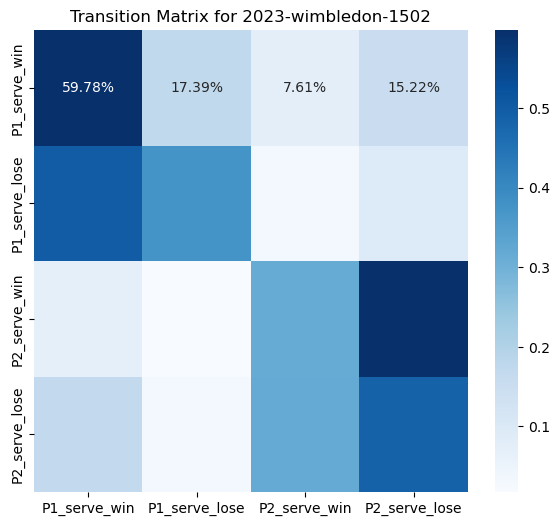

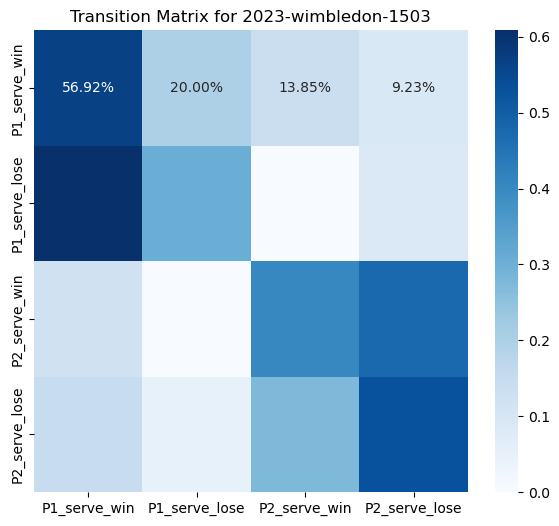

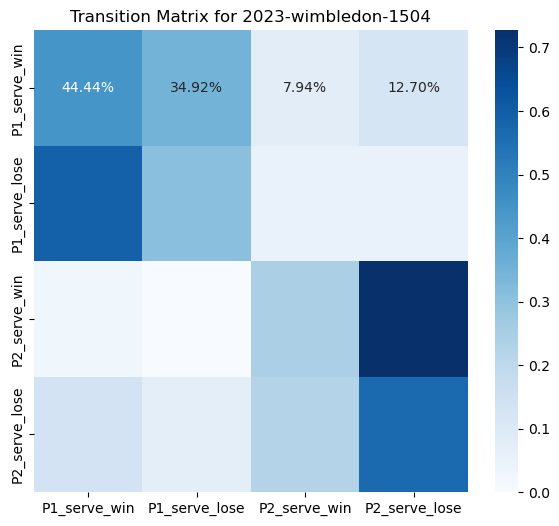

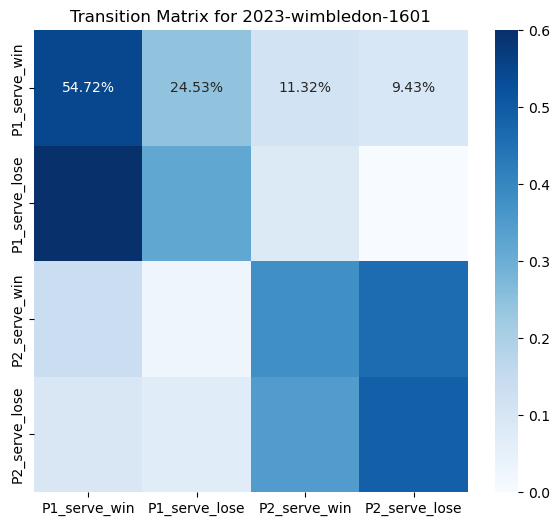

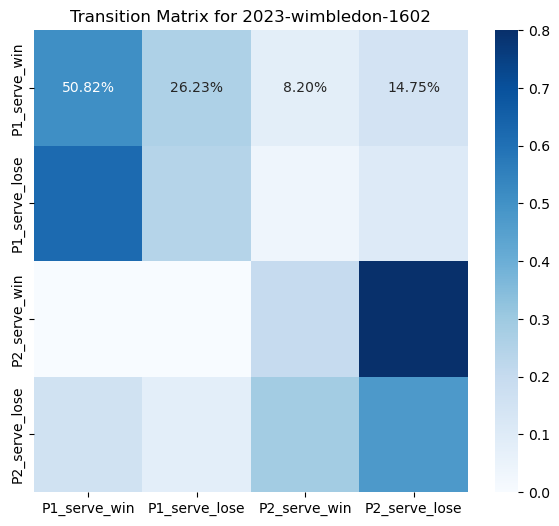

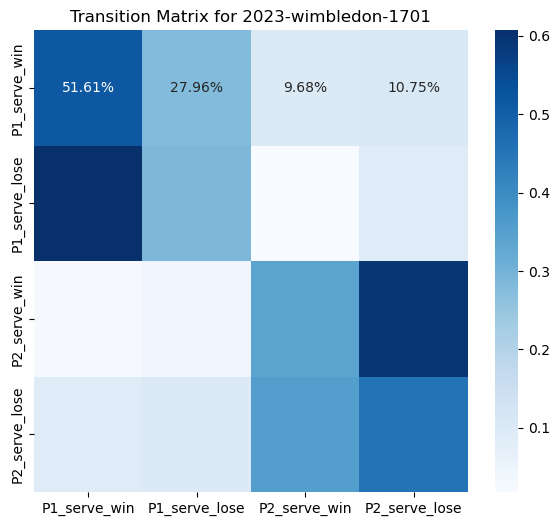

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Iterate over transition matrices
for i, transition_matrix in enumerate(transition_matrices):
    # Create a new figure for each matrix
    plt.figure(figsize=(7, 6))

    # Create a heatmap
    sns.heatmap(transition_matrix, annot=True, fmt=".2%", cmap='Blues', annot_kws={"size": 10})

    # Add a title using the value of match[id]
    plt.title(f'Transition Matrix for {match[i]}')

    # Show the plot
    plt.show()

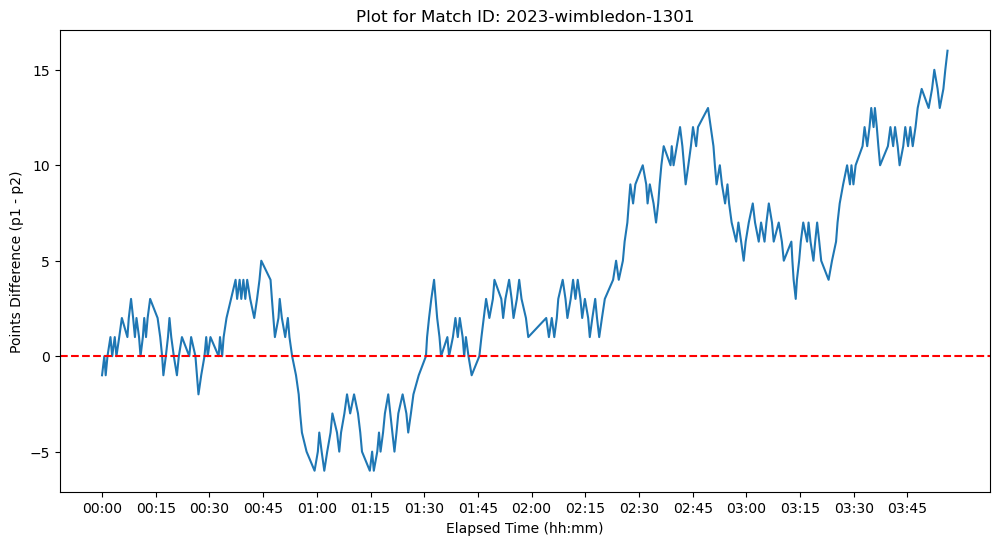

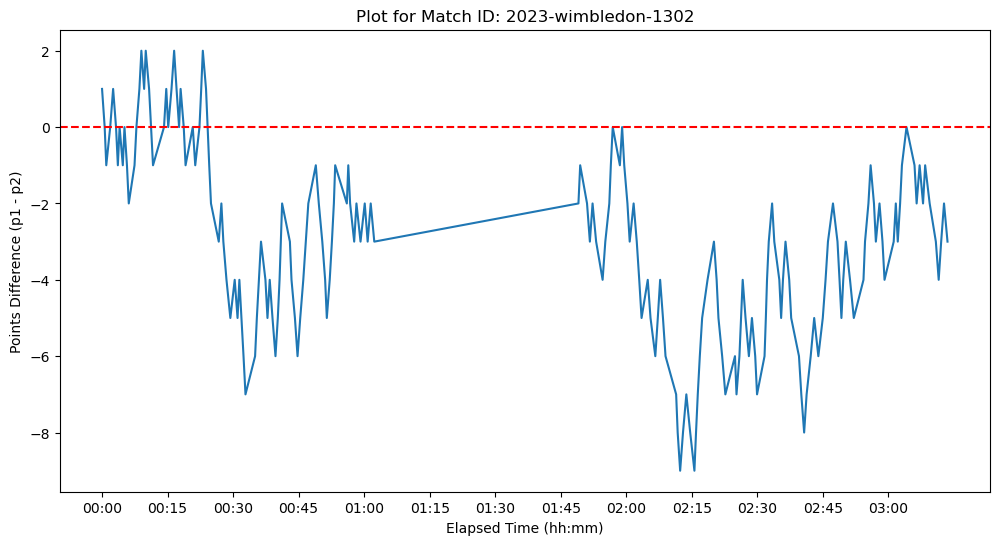

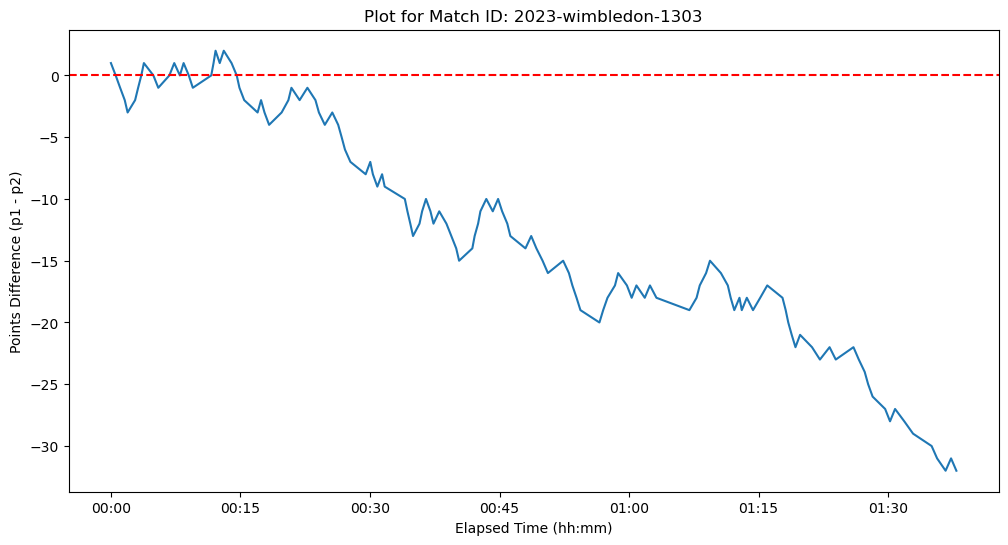

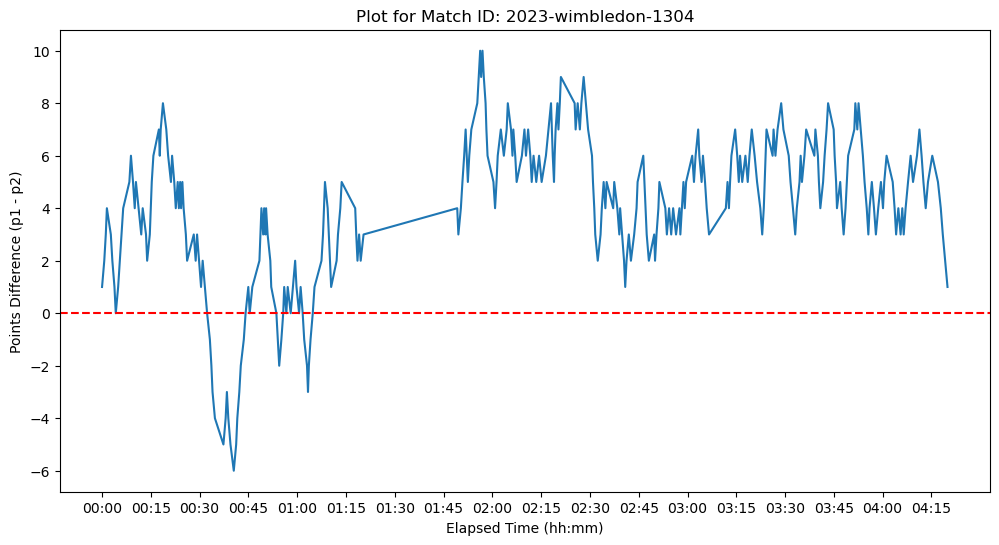

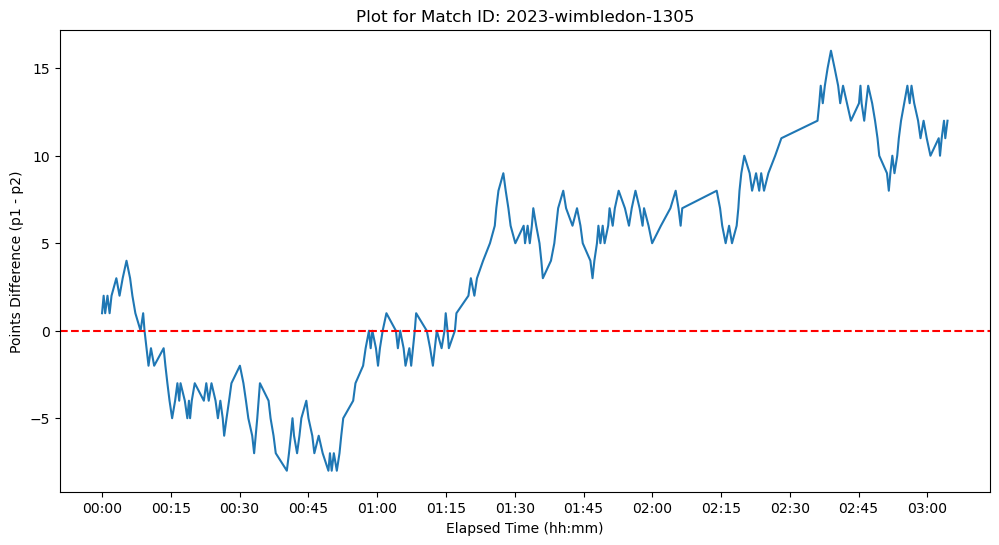

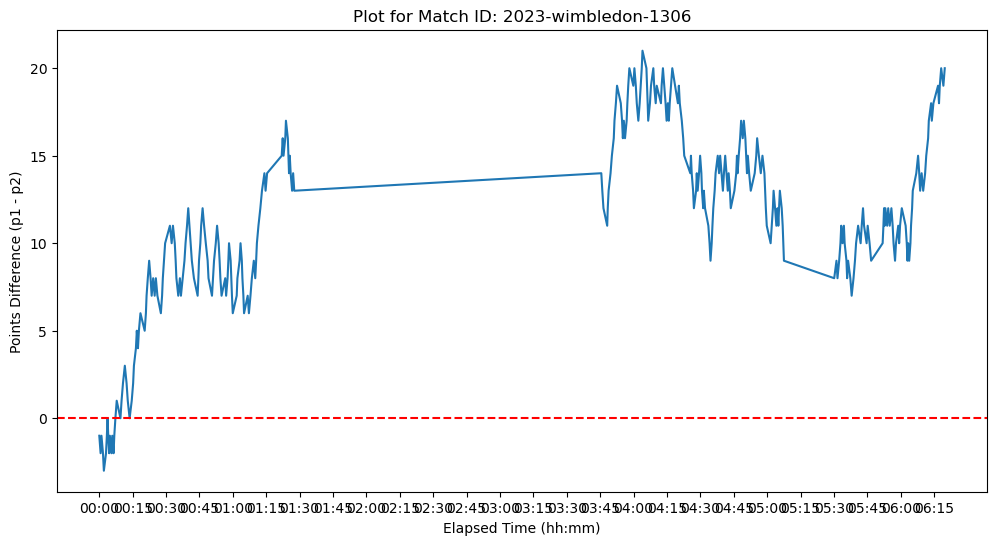

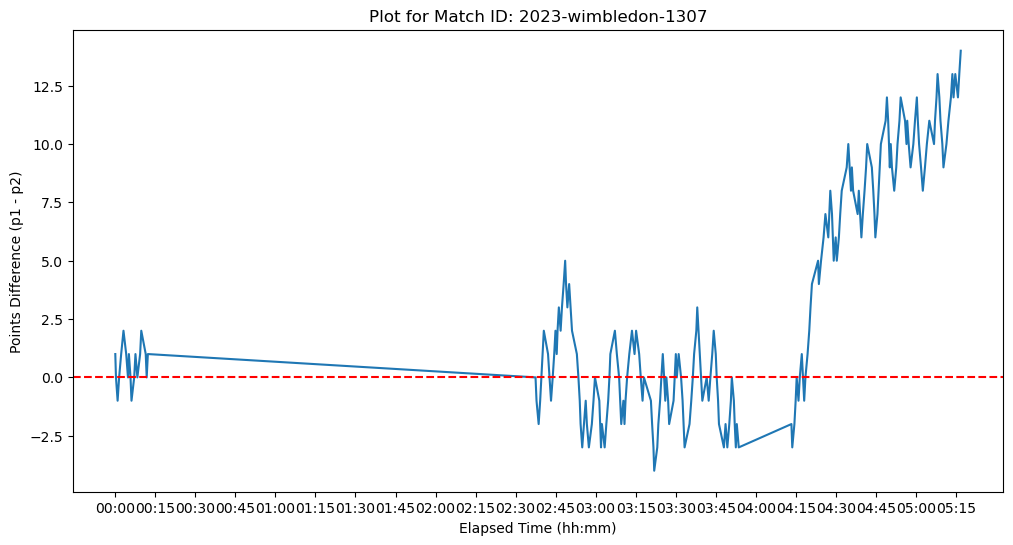

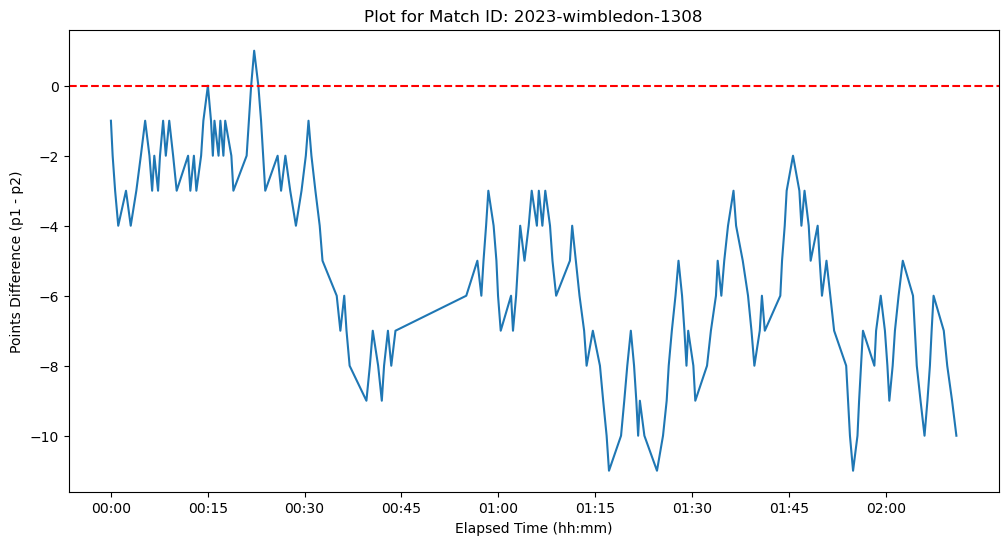

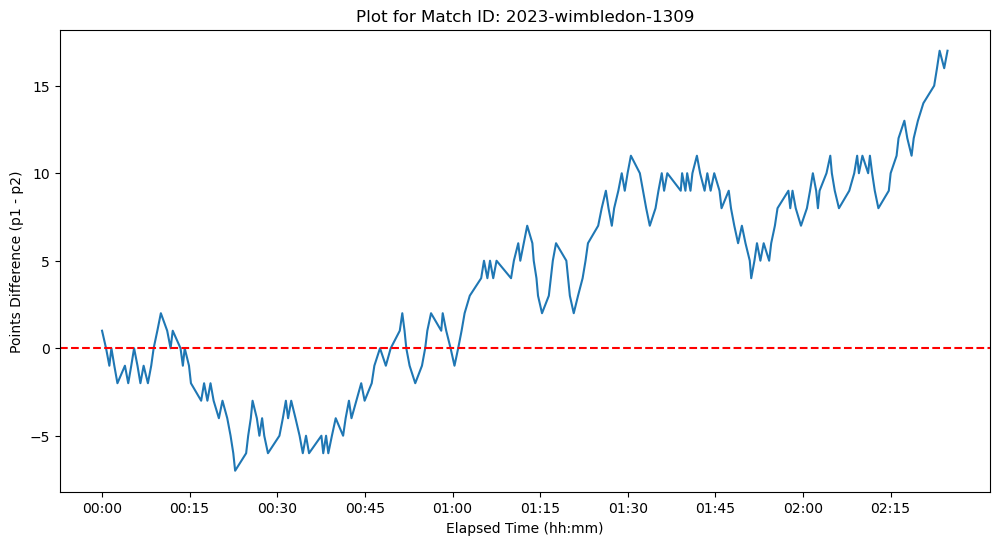

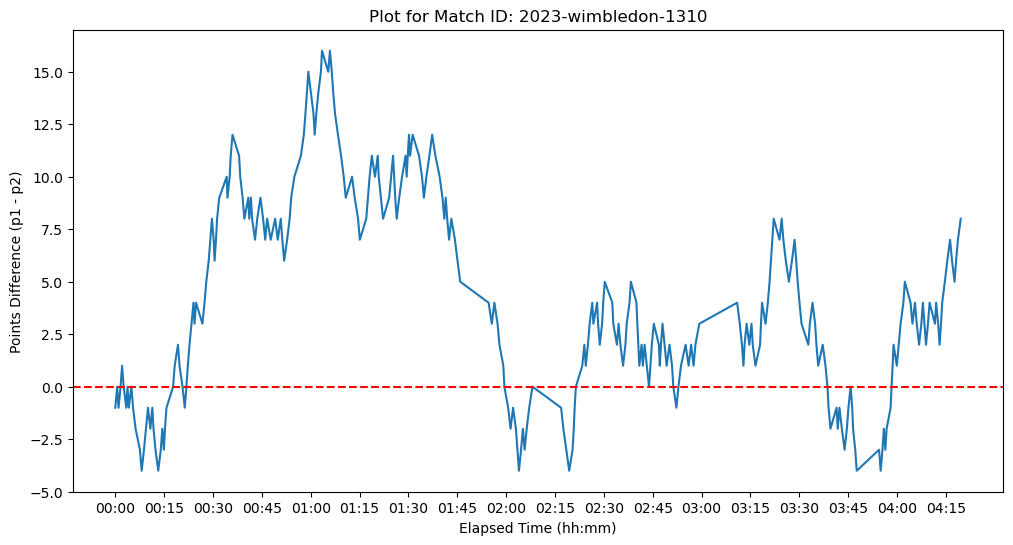

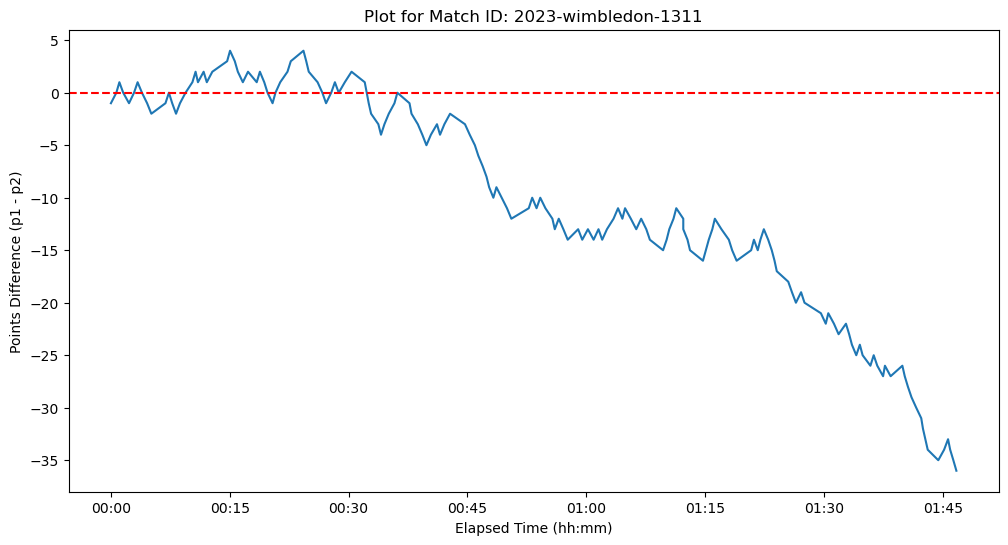

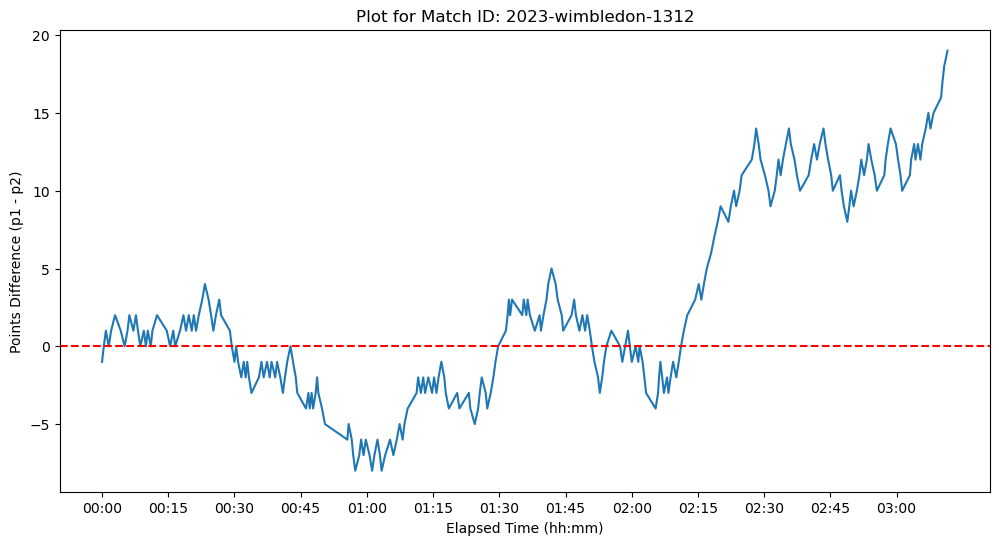

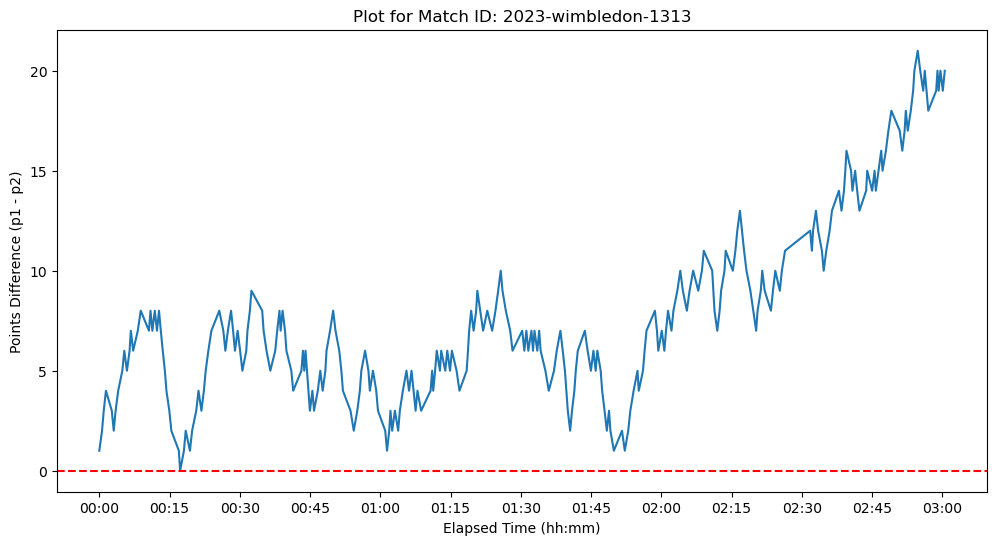

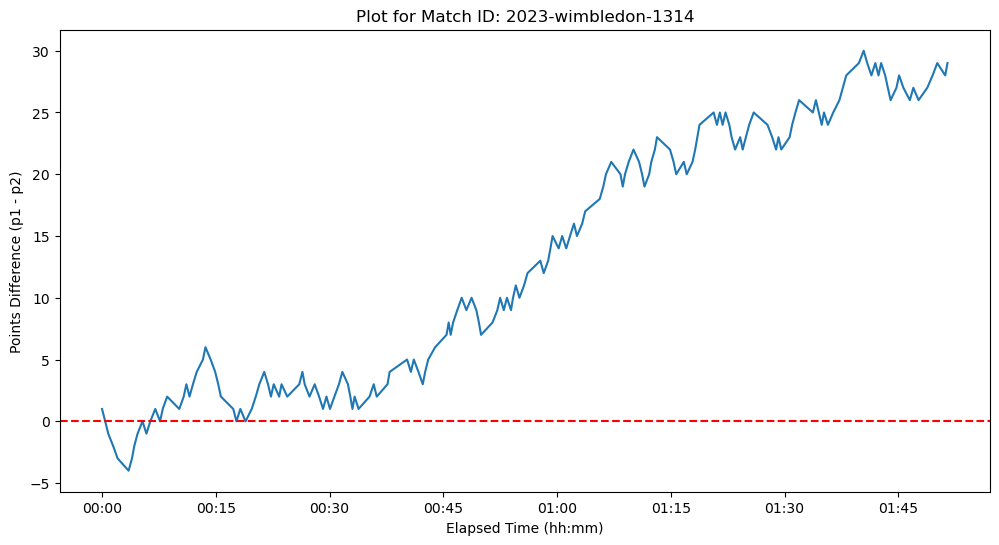

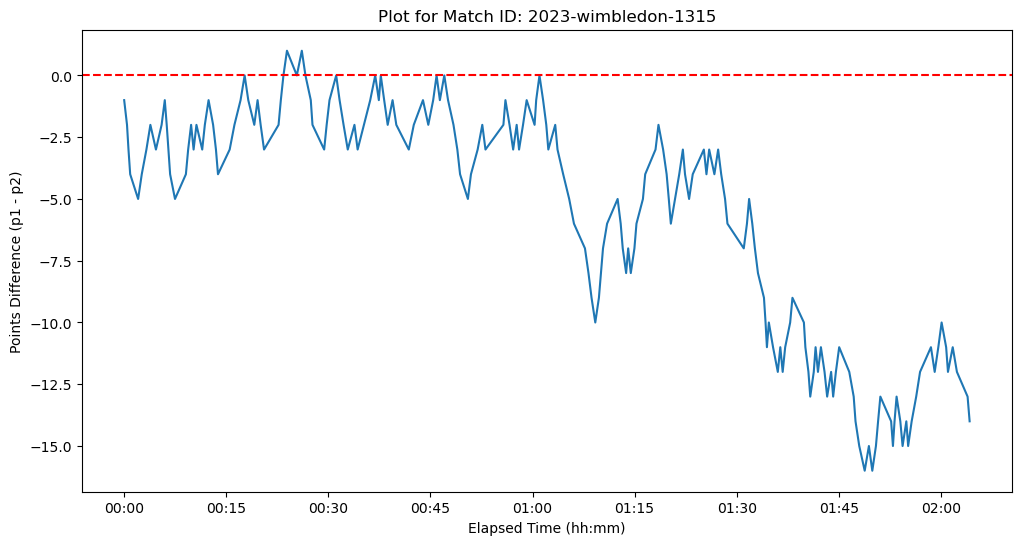

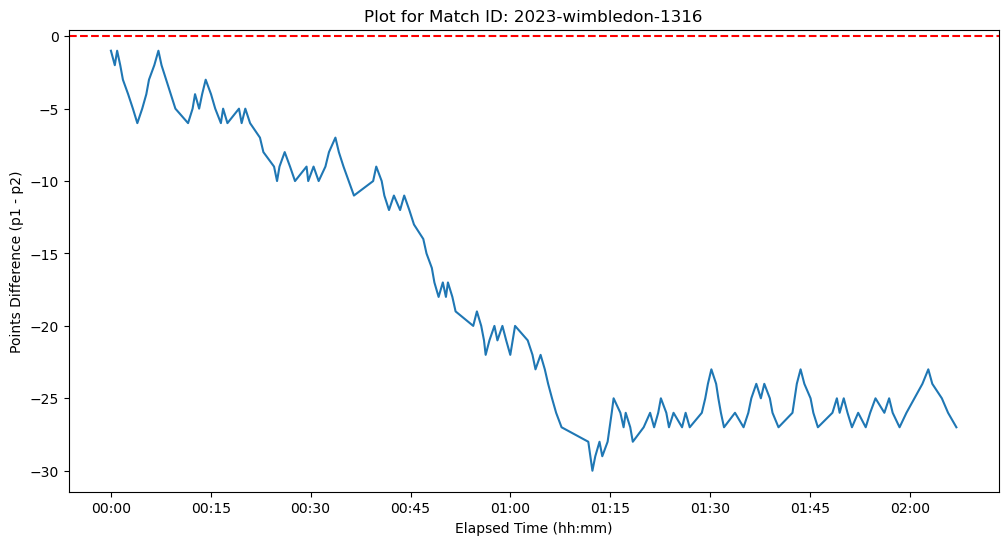

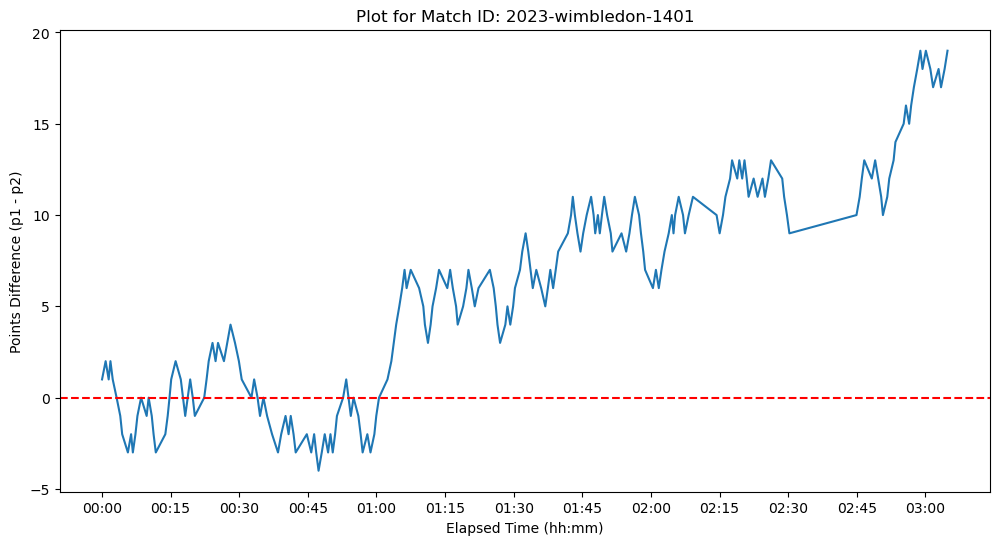

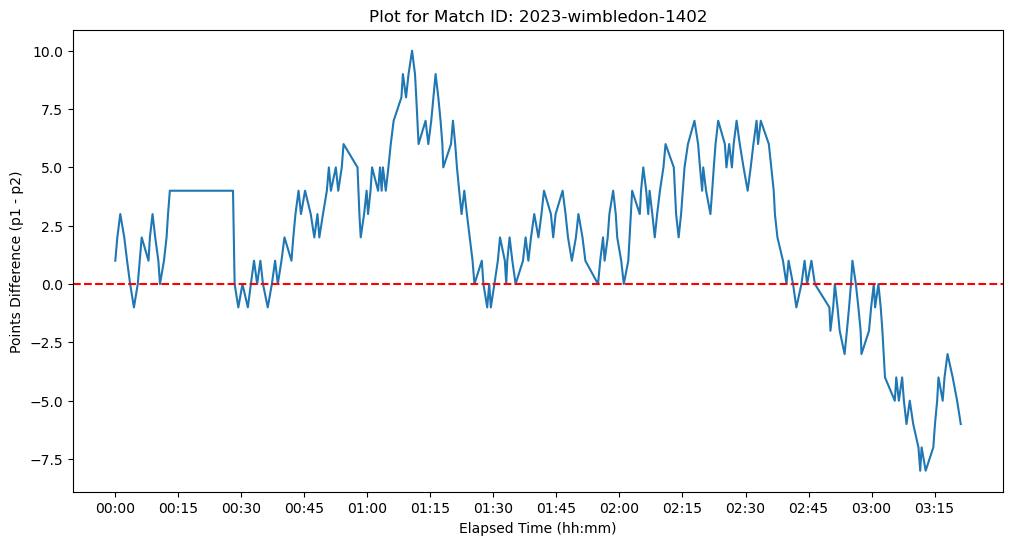

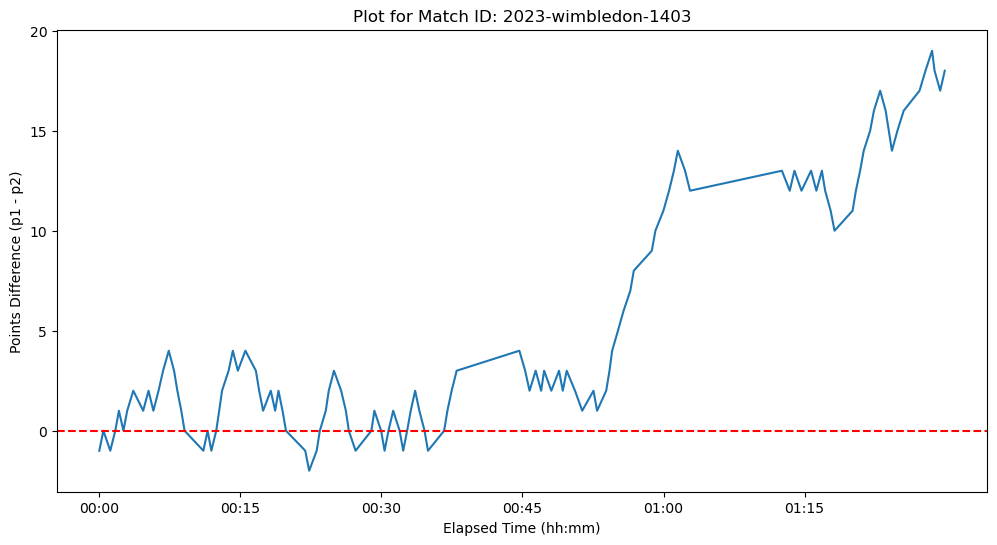

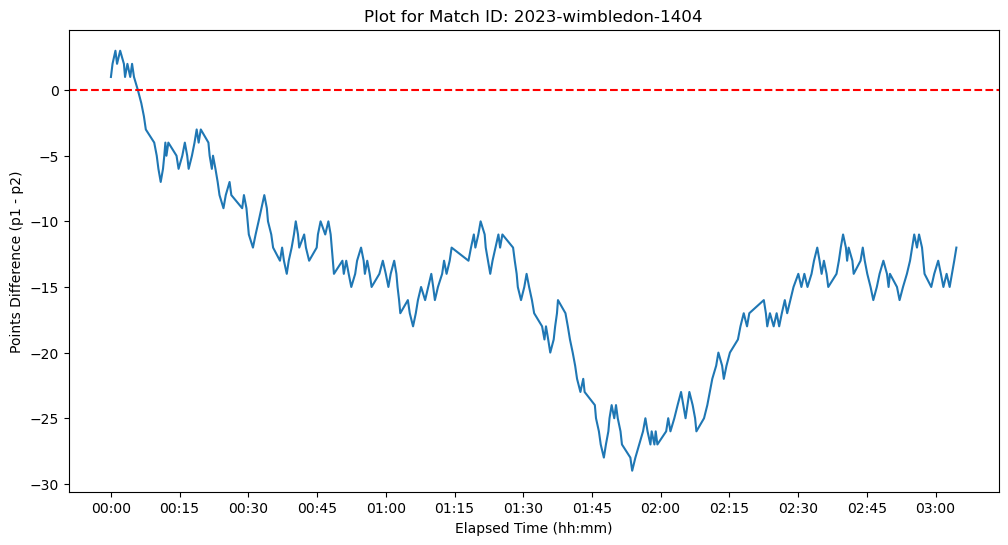

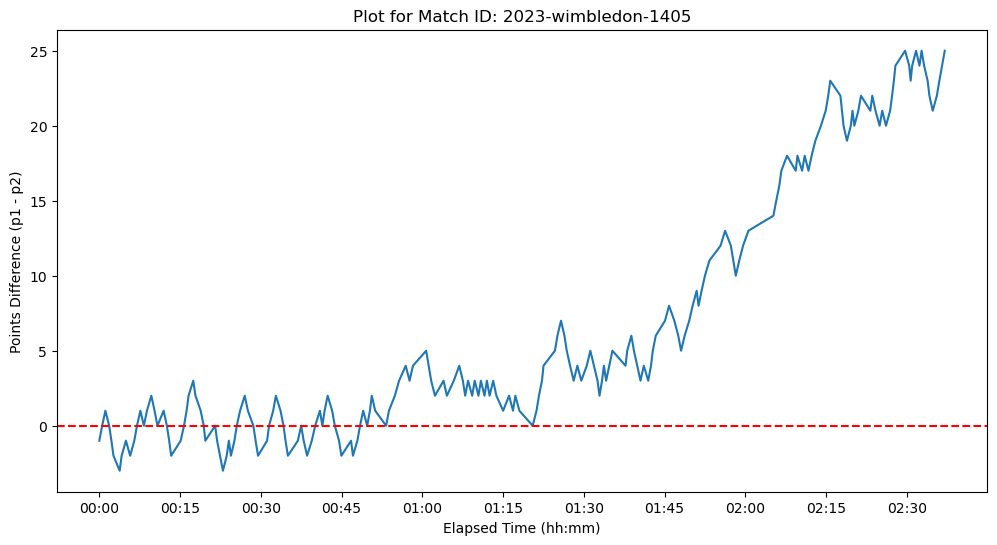

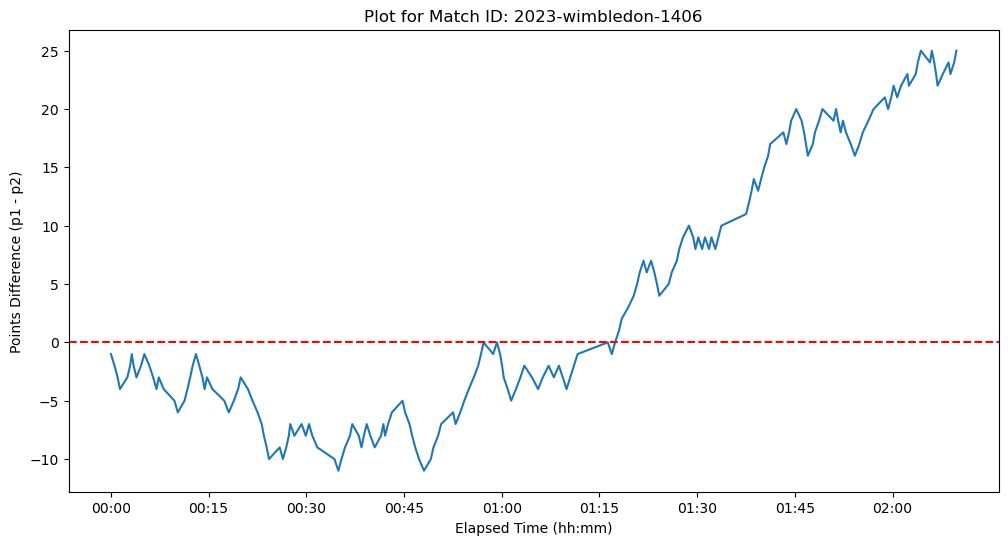

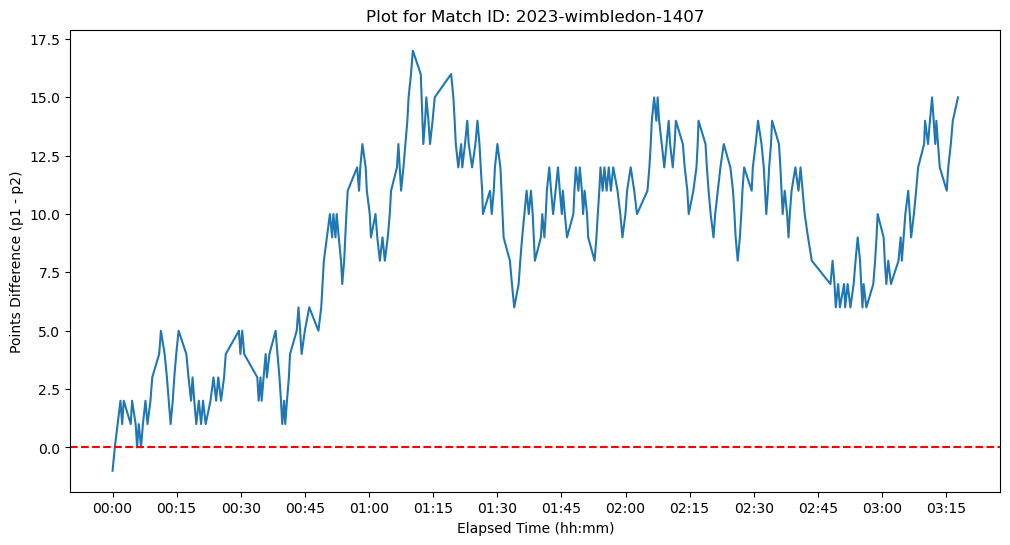

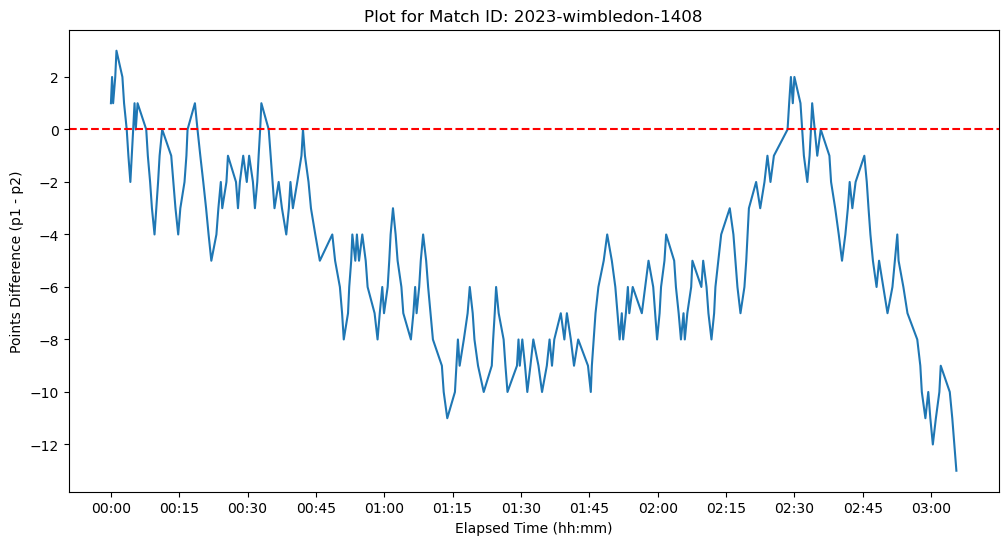

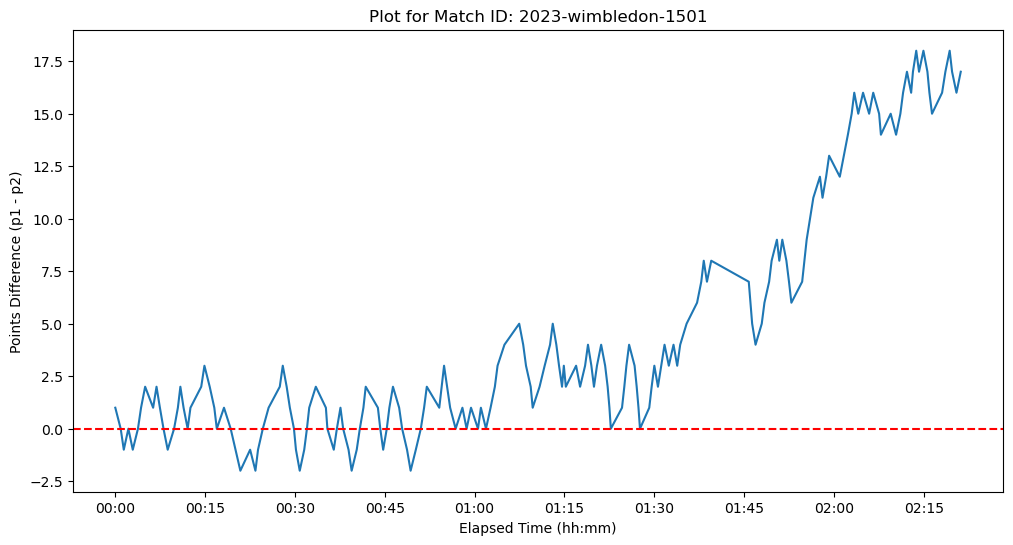

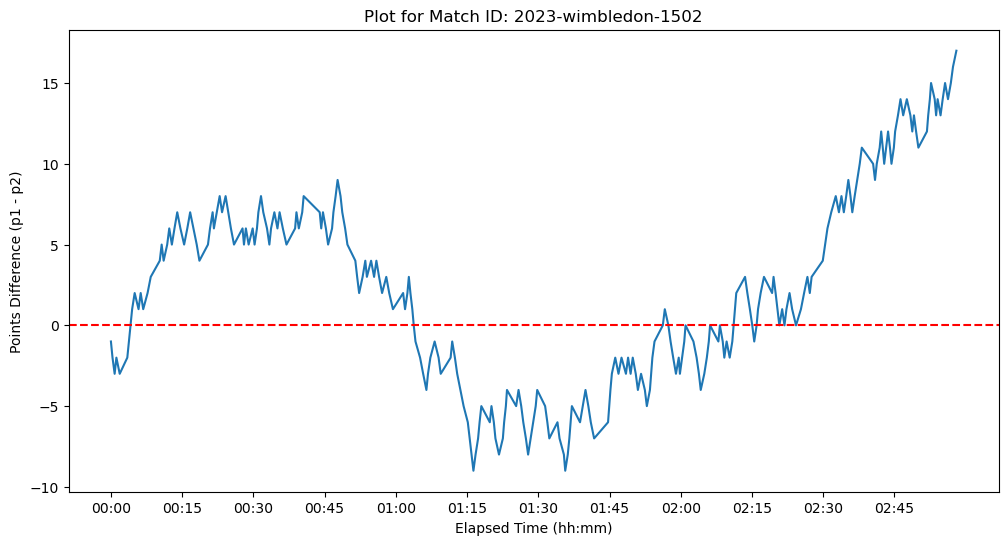

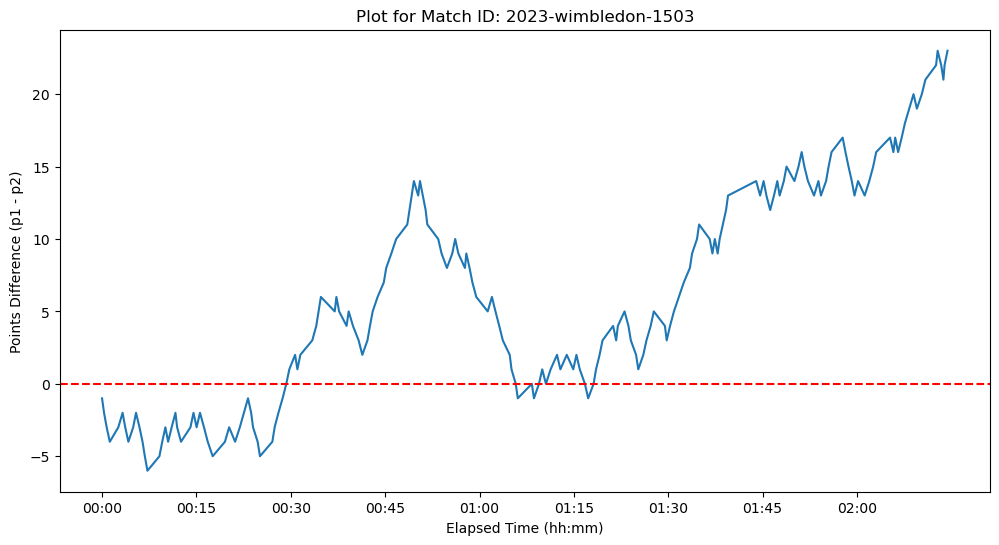

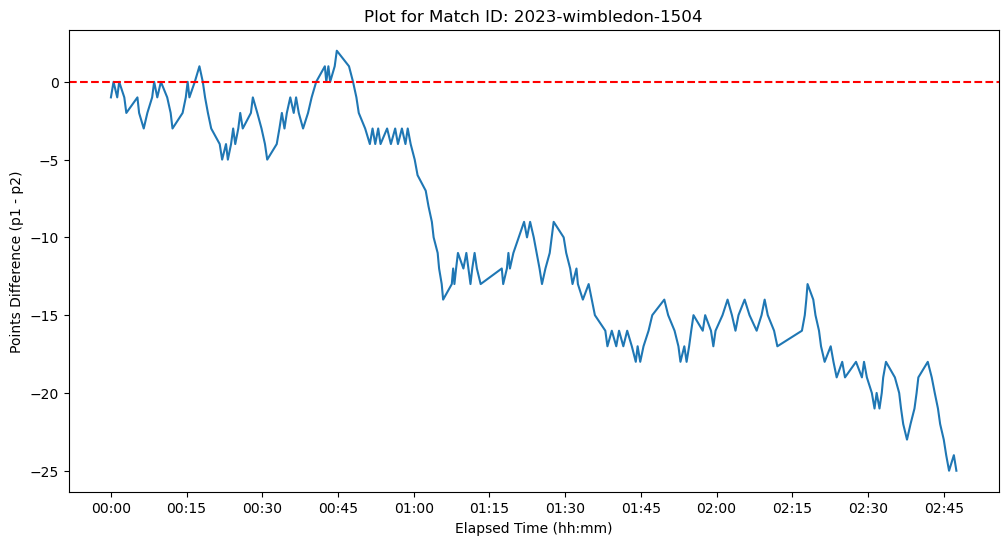

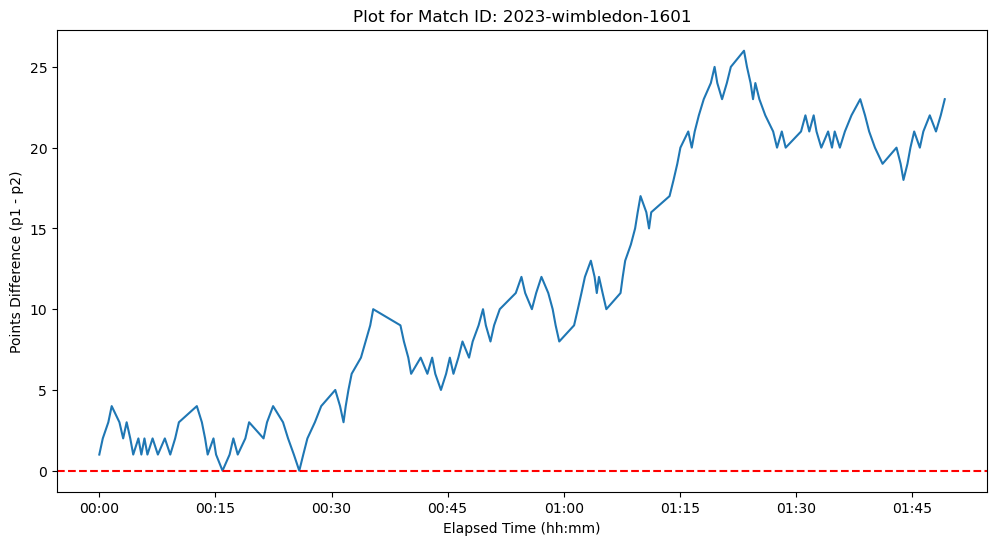

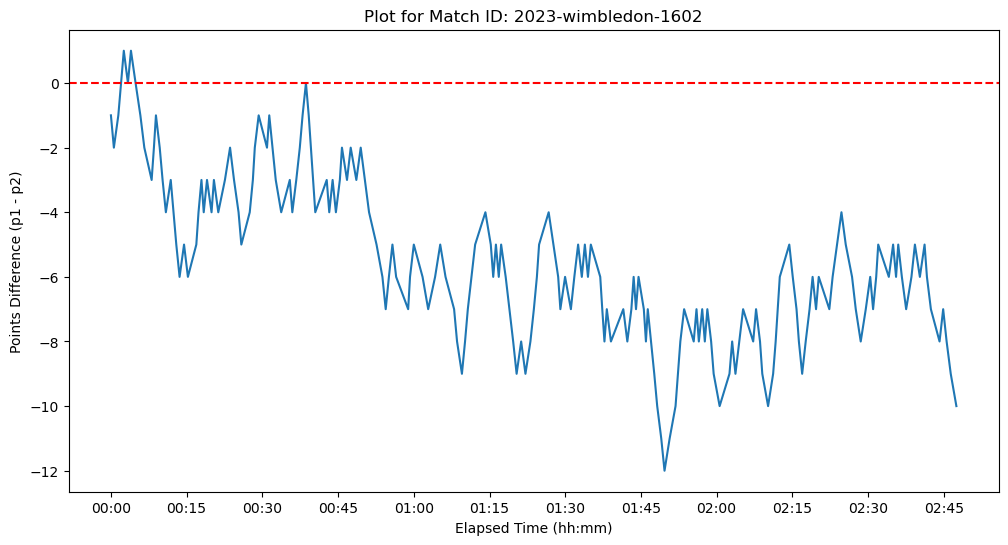

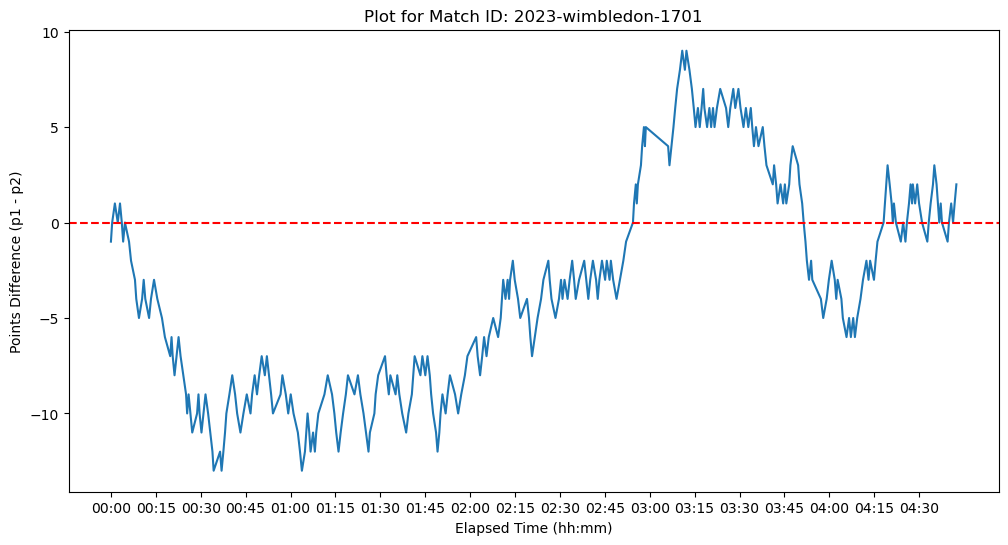

In [73]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def draw_plot(id, subdata):
        # Set the figure size (width, height)
    plt.figure(figsize=(12, 6))

    # Calculate the number of 1s subtracted by the number of 0s in 'point_victor'
    y_values = subdata[match[id]]['p1_points_won'] - subdata[match[id]]['p2_points_won']
    #print(y_values)
    # Get the 'elapsed_time' values and convert them to total number of seconds
    x_values = subdata[match[id]]['elapsed_time'].dt.total_seconds()
    #print(x_values)
    # Create the bar plot
    plt.plot(x_values, y_values)

    # Create xticks every 15 minutes
    x_ticks = np.arange(min(x_values), max(x_values), 15*60)  # 15 minutes in seconds
    x_tick_labels = [(datetime.min + timedelta(seconds=s)).time().strftime('%H:%M') for s in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)

        # Add x and y labels
    plt.xlabel('Elapsed Time (hh:mm)')
    plt.ylabel('Points Difference (p1 - p2)')

        # Add a title
    plt.title(f'Plot for Match ID: {match[id]}')

    # Add a horizontal line at y=0
    plt.axhline(0, color='red', linestyle='--')

    # Show the plot
    plt.show()

# Usage:
for id in range(len(match)):
    #print(id)
    draw_plot(id, subdata)
